In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_30112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 236513.43           | 238242.43           | 240335.0            | 241935.0            | 243169.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:49<00:00, 30.14trial/s, best loss: 0.6270860994024327]
best parameters
 {'E_hosp_ratio': 0.26692188774284453, 'I_hosp_ratio': 0.3969173714778467, 'P_fatal': 0.028224216723171842, 'T_inc': 4.2796883505308845, 'T_inf': 3.641978114466535, 'T_recov': 11.2851318555246, 'T_recov_fatal': 20.607937095182866, 'lockdown_R0': 0.8168930306163871}
Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_30112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 179                 | 180                 | 181                 | 182                 | 183                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-22 00:00:00 | 2020-10-23 00:00:00 | 2020-10-24 00:00:00 | 2020-10-25 00:00:00 | 2020-10-26 00:00:00 |

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:49<00:00, 30.55trial/s, best loss: 0.6965284175545344]
best parameters
 {'E_hosp_ratio': 0.35655868992127276, 'I_hosp_ratio': 0.3325518199526073, 'P_fatal': 0.042066387944589285, 'T_inc': 4.648450807677904, 'T_inf': 3.817578369470605, 'T_recov': 9.824289822200456, 'T_recov_fatal': 34.756401628885655, 'lockdown_R0': 0.7776143292280128}


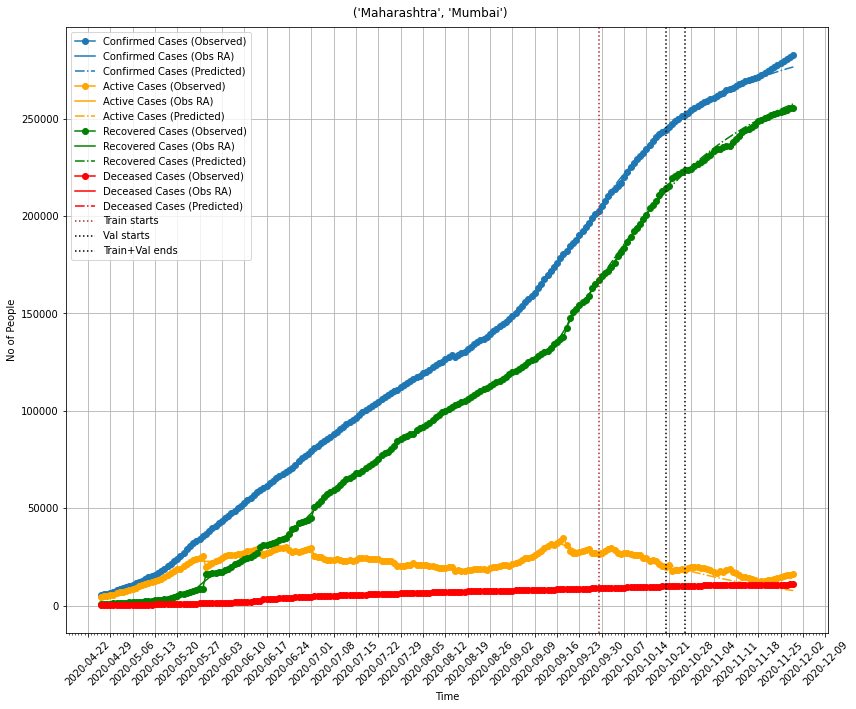

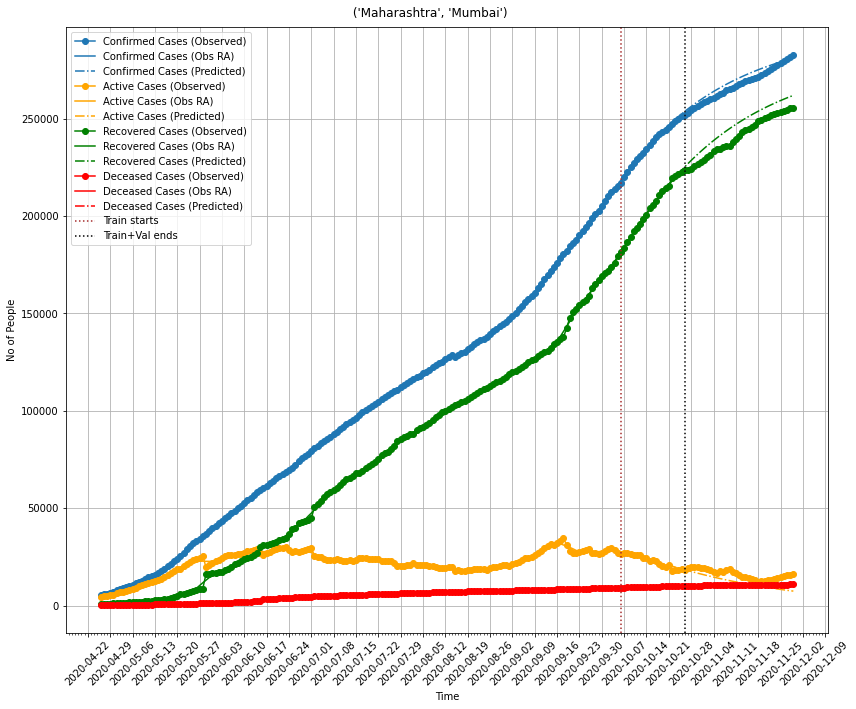

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [9]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.26692188774284453,
 'I_hosp_ratio': 0.3969173714778467,
 'P_fatal': 0.028224216723171842,
 'T_inc': 4.2796883505308845,
 'T_inf': 3.641978114466535,
 'T_recov': 11.2851318555246,
 'T_recov_fatal': 20.607937095182866,
 'lockdown_R0': 0.8168930306163871}

In [10]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.35655868992127276,
 'I_hosp_ratio': 0.3325518199526073,
 'P_fatal': 0.042066387944589285,
 'T_inc': 4.648450807677904,
 'T_inf': 3.817578369470605,
 'T_recov': 9.824289822200456,
 'T_recov_fatal': 34.756401628885655,
 'lockdown_R0': 0.7776143292280128}

## Loss Dataframes

### M1 Loss DataFrame

In [11]:
predictions_dict['m1']['df_loss']

,train,val
total,0.46558,0.595756
active,2.60794,4.4833
recovered,0.657561,1.03088
deceased,0.163402,0.286534


### M2 Loss DataFrame

In [12]:
predictions_dict['m2']['df_loss']

,train
total,0.231394
active,2.91868
recovered,0.279569
deceased,0.48563


## Sensitivity Plot

100%|██████████| 101/101 [00:00<00:00, 118.08it/s]


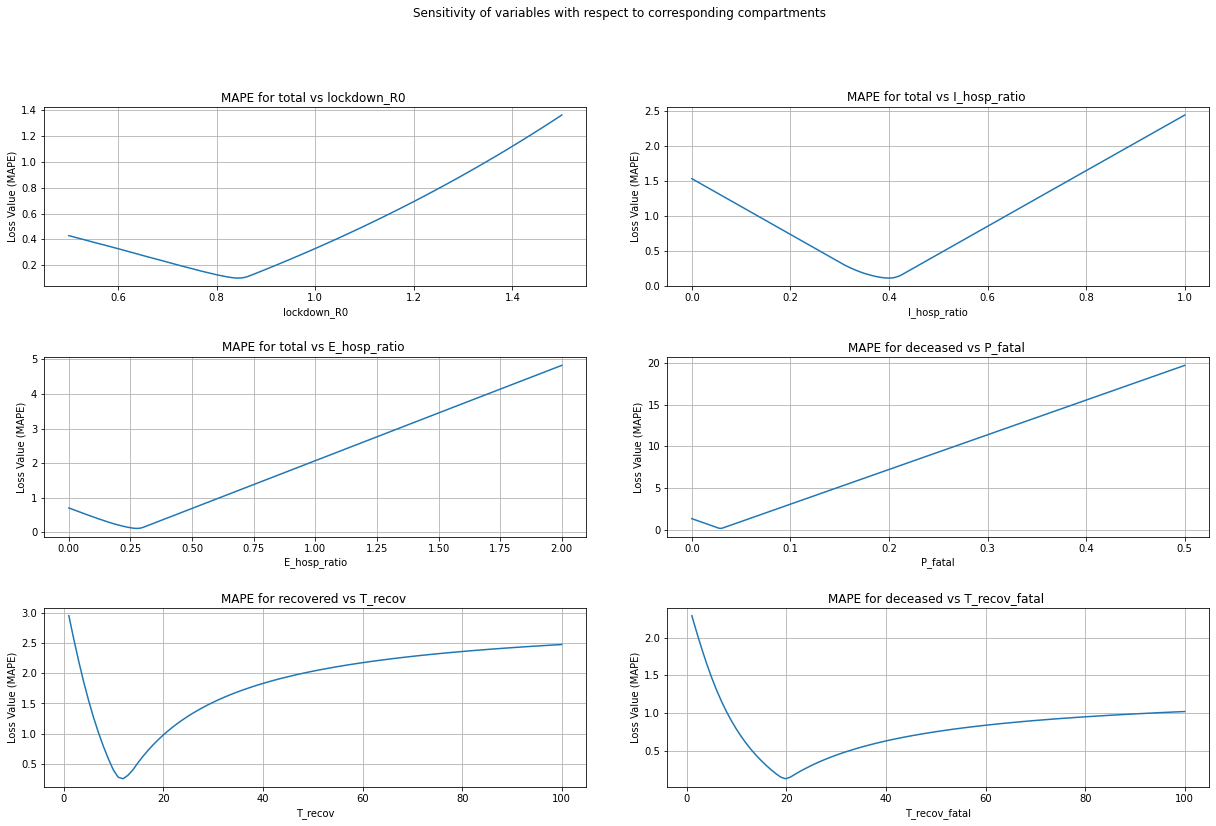

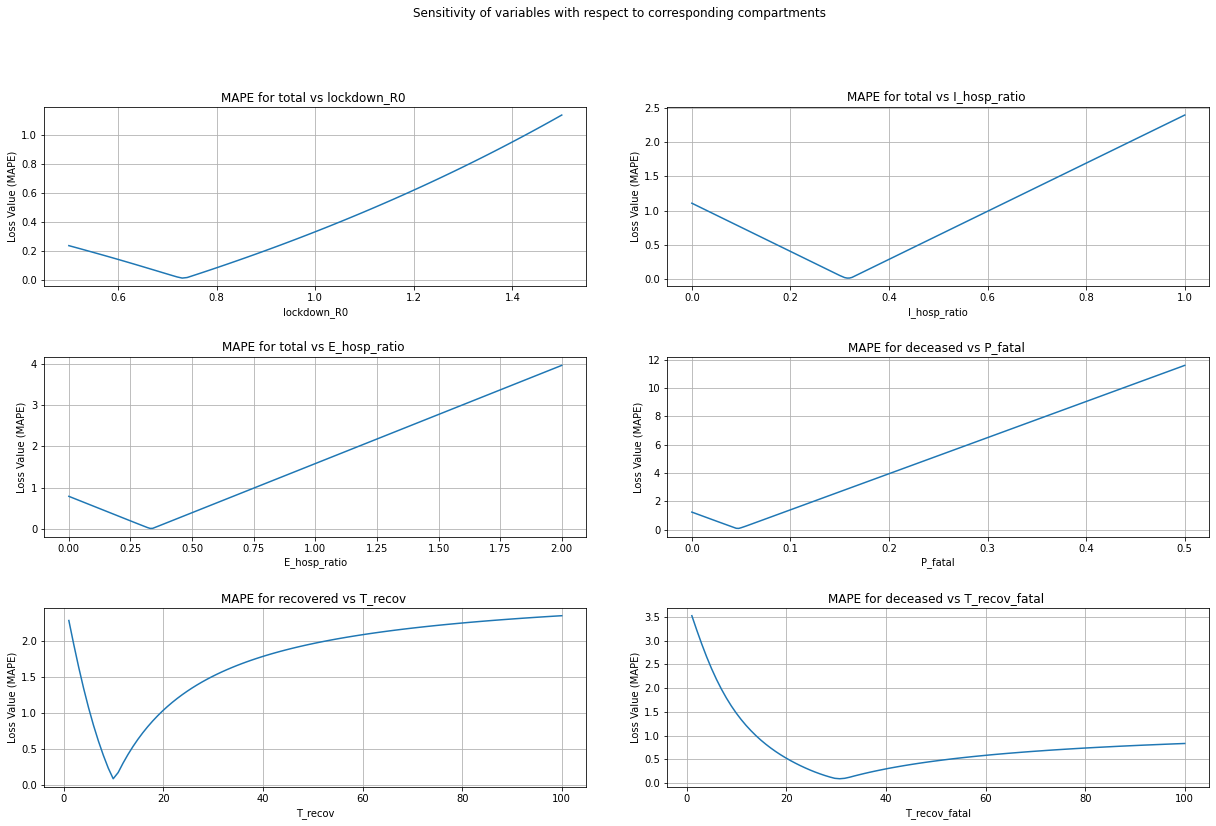

In [13]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

0it [00:00, ?it/s]

getting forecasts ..
getting forecasts ..


1500it [00:10, 137.33it/s]
15it [00:00, 141.93it/s]

getting forecasts ..


1500it [00:11, 132.56it/s]


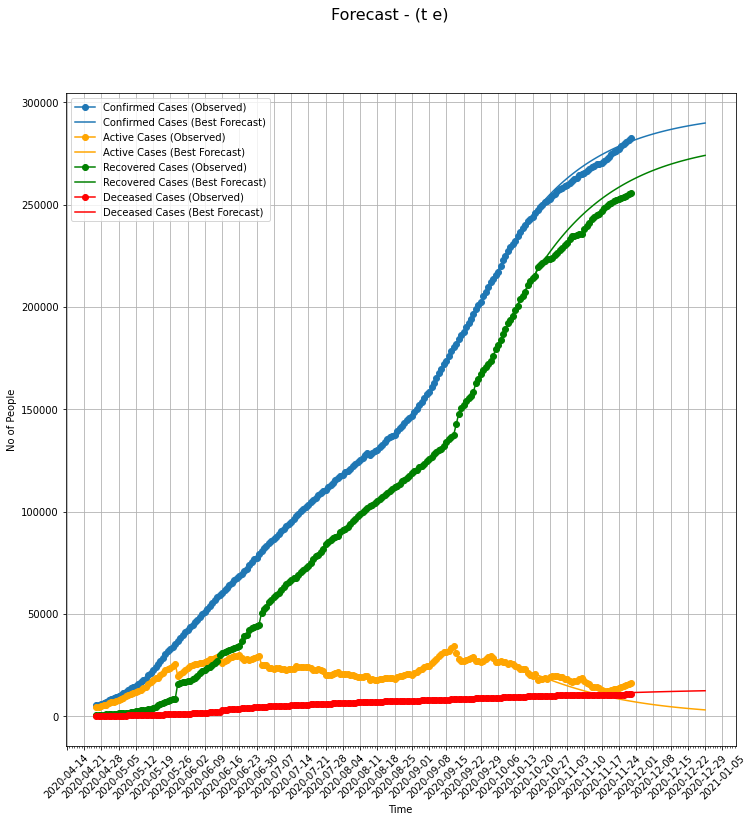

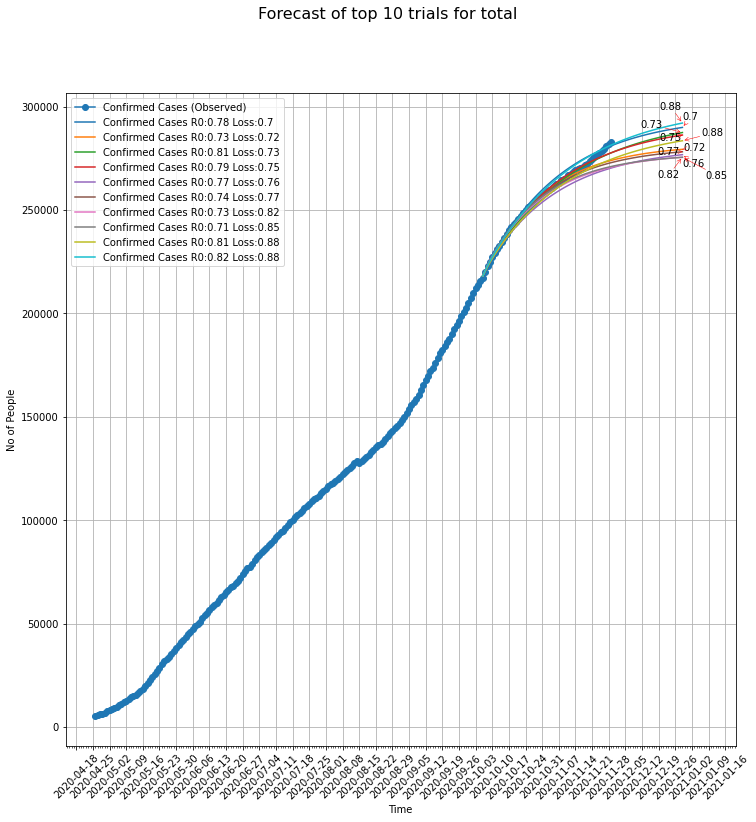

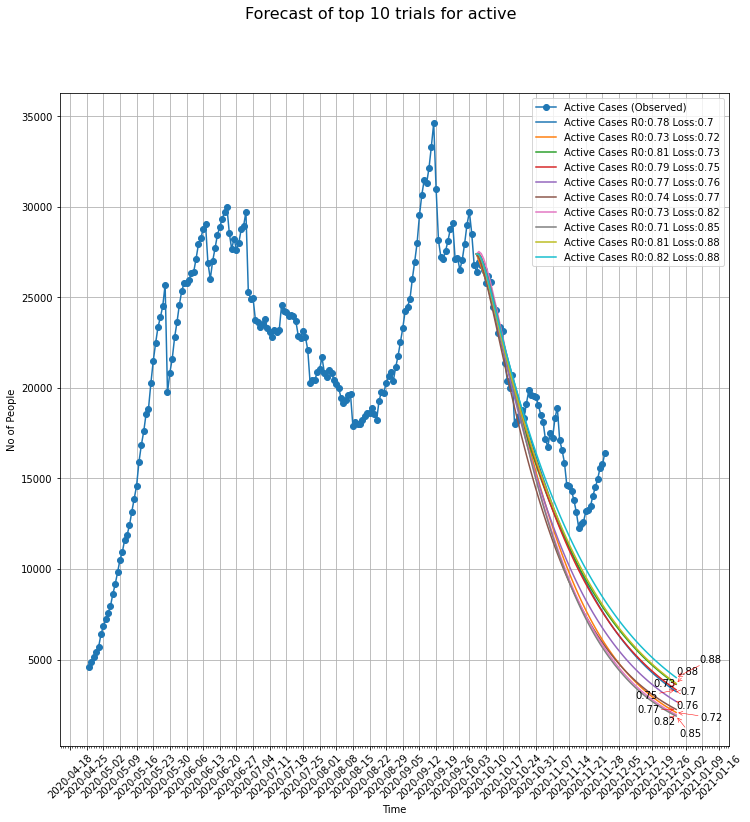

In [14]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [21]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

29it [00:00, 135.92it/s]

getting forecasts ..


1500it [00:09, 150.01it/s]
15it [00:00, 148.38it/s]

getting forecasts ..


1500it [00:09, 152.12it/s]
100%|██████████| 101/101 [01:43<00:00,  1.02s/it]


Best beta - 10.0
Min Loss - 1.7767528167573596


In [22]:
uncertainty.ensemble_mean_forecast['df_loss']

{'active': 4.835673487429177,
 'recovered': 1.304116958984526,
 'deceased': 0.16811979017080667,
 'total': 0.7991010304449284}

In [23]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [24]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

ValueError: Could not interpret input 'date'

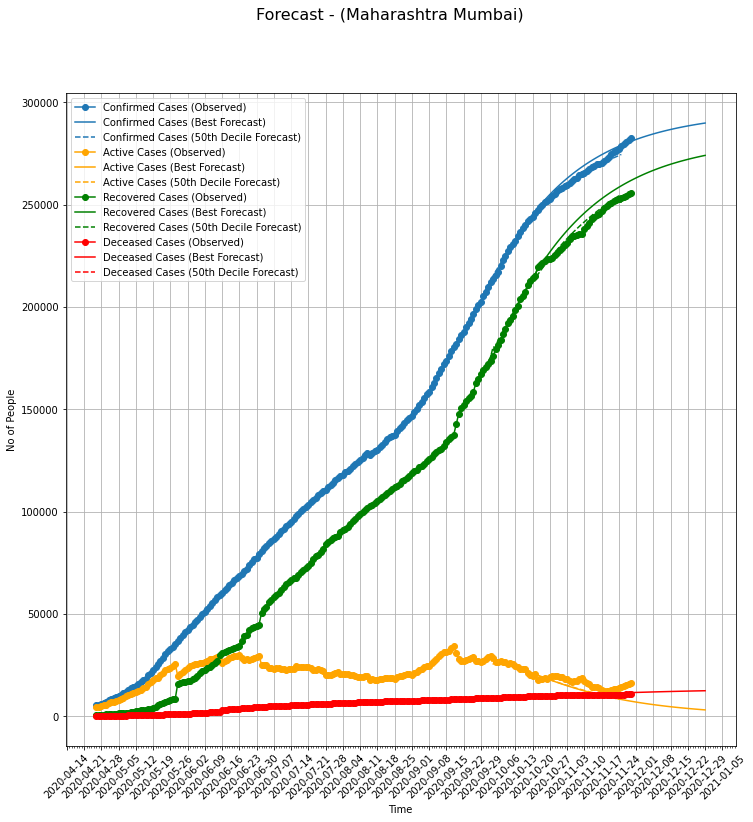

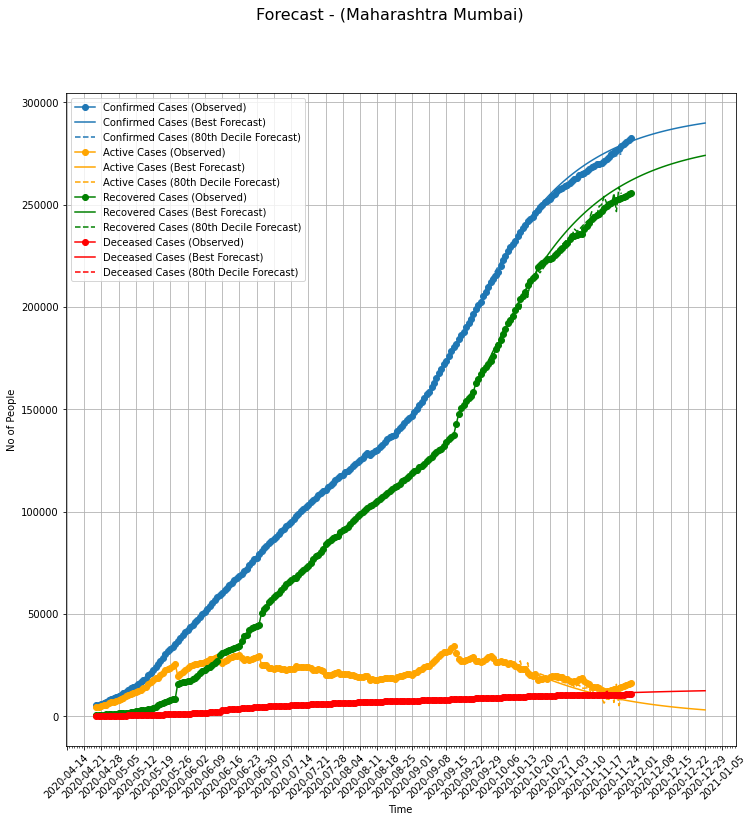

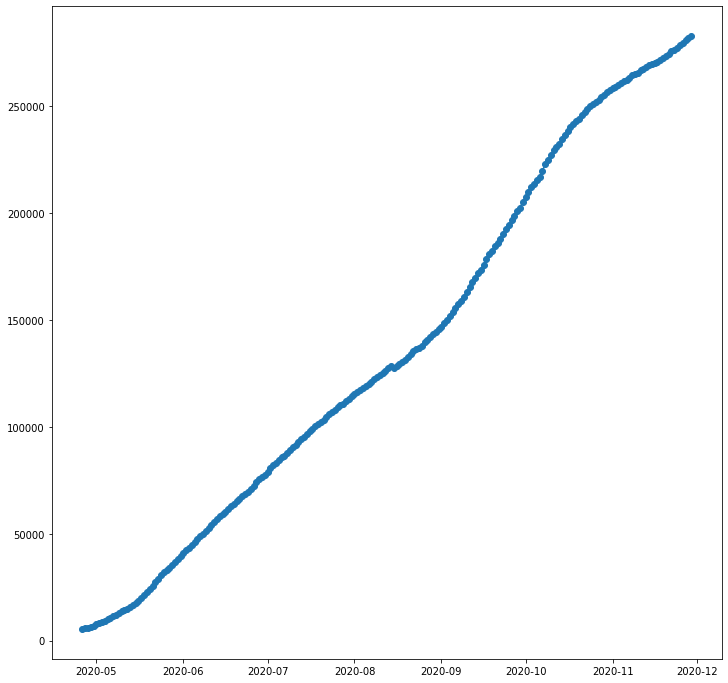

In [25]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

In [20]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')